# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2018-CS109A/blob/master/content/styles/iacs.png?raw=true"> CS-S109A Introduction to Data Science 

## Lecture 5: Cross-Validation and Regularization

**Harvard University**<br>
**Summer 2020**<br>
**Instructors:** Kevin Rader<br>
**Authors:** Rahul Dave, David Sondak, Will Claybaugh, Pavlos Protopapas, Chris Tanner, Kevin Rader

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

# Table of Contents 
<ol start="0">
<li> Learning Goals </li>
<li> Cross-Validation</li>
<li> Regulatization</li>
<li> </li>
    

## Learning Goals

This Jupyter notebook accompanies Lecture 5. By the end of this lecture, you should be able to:

- Know how to manually perform random subsets cross-validation
- Perform $k$-fold cross-v alidation both manually and using provided libraries
- Perform both forms of regularization (Ridge and LASSO) and understand the most basic use differences


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels as sm
import statsmodels.regression.linear_model as lm

from sklearn.model_selection import KFold

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

## Part 0: Reading the data 

We will be using the same data as last week (both the train and test splits): modeling `votergap` from the 2016 election (Trump-Clinton) from many predictors in the `county_election` dataset.

We start by reading in the datasets for you and refitting some regression models from last week:

**Important note: use the training dataset for all exploratory analysis and model fitting.  Only use the test dataset to evaluate and compare models.**


In [3]:

train = pd.read_csv("../data/county_election_train.csv")
test = pd.read_csv("../data/county_election_test.csv")

#recall we log-transformed several of the variables and did a little imputation in cancer variable (with the median)
train['log_density'] = np.float64(np.log(train['density']))
train['log_minority'] = np.float64(np.log(train['minority']))
train['log_population'] = np.log(train['population'])
train['log_hispanic'] = np.log(train['hispanic'])

test['log_density'] = np.float64(np.log(test['density']))
test['log_minority'] = np.float64(np.log(test['minority']))
test['log_population'] = np.log(test['population'])
test['log_hispanic'] = np.log(test['hispanic'])

# imputing median cancer rate for the 40 or so counties with missing cancer rates
train['cancer'].loc[train['cancer'].isnull()] = np.median(train['cancer'])
test['cancer'].loc[test['cancer'].isnull()] = np.median(train['cancer'])



/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


**Q0.1** How were missing values imputed for the variable `cancer` in the test set?  Why was this choice made?

*your answer here*

In [4]:
# and we fit the simple regression model for y = votergap and x = log_density in both sklearn and statmodels

predictors = ['log_population','log_hispanic', 'log_minority', 'female', 
             'unemployed', 'income', 'nodegree', 'bachelor', 'inactivity', 'obesity', 'log_density']
X_train = train[predictors]
X_test = test[predictors]

regress_maineffects = LinearRegression(fit_intercept=True).fit(X_train, train['votergap'])

r2_test_maineffects = sk.metrics.r2_score(test['votergap'], regress_maineffects.predict(X_test))
print("R-squared on the test set for the main effects model:", r2_test_maineffects)

R-squared on the test set for the main effects model: 0.5752558339850569


In [5]:
# And then we fit a model to 

X_interact = PolynomialFeatures(2, interaction_only=False, include_bias=True).fit_transform(train[predictors])
print("There are", X_interact.shape[1]-train[predictors].shape[1]-1,"interaction terms in the design matrix for this model.")

regress_interact = LinearRegression(fit_intercept=False).fit(X_interact, train['votergap'])

r2_test_interact = sk.metrics.r2_score(test['votergap'], regress_interact.predict(
    PolynomialFeatures(2, interaction_only=False, include_bias=True).fit_transform(test[predictors])))
print("R-squared on the test set for the full interaction model:", r2_test_interact)

There are 66 interaction terms in the design matrix for this model.
R-squared on the test set for the full interaction model: 0.7121772296069138


In [9]:
# And lastly we did variable selection on this full model with interaction (backwards sequential variable selection)

df_backwards = pd.DataFrame(X_interact)
cutoff = 0.2

for i in np.arange(df_backwards.shape[1]):
    model_temp = lm.OLS(train['votergap'],df_backwards).fit()
    if(np.max(model_temp.pvalues) > cutoff):
        print("Predictor#:", np.argmax(model_temp.pvalues), "with associated p-value of" ,np.max(model_temp.pvalues))
        df_backwards = df_backwards.drop(pd.DataFrame(X_interact).columns[np.argmax(model_temp.pvalues)],axis=1)
    else:
        break

regress_backwards = LinearRegression(fit_intercept=False).fit(df_backwards, train['votergap'])
df_backwards.shape

X_interact_test = PolynomialFeatures(2, interaction_only=False, include_bias=True).fit_transform(test[predictors])
X_backwards_test = pd.DataFrame(X_interact_test)[df_backwards.columns]

r2_test_backwards = sk.metrics.r2_score(test['votergap'], regress_backwards.predict(X_backwards_test))
print("R-squared on the test set for the full interaction model:", r2_test_backwards)

Predictor#: 65 with associated p-value of 0.9809439044018047
Predictor#: 59 with associated p-value of 0.9305643717295858
Predictor#: 30 with associated p-value of 0.9249852513988832
Predictor#: 46 with associated p-value of 0.9084284356381296
Predictor#: 5 with associated p-value of 0.9918462081475021
Predictor#: 72 with associated p-value of 0.9333415365189452
Predictor#: 71 with associated p-value of 0.9786271608656434
Predictor#: 70 with associated p-value of 0.9804924564077684
Predictor#: 20 with associated p-value of 0.9937354307652169
Predictor#: 68 with associated p-value of 0.8927774675943259
Predictor#: 26 with associated p-value of 0.9332163015373882
Predictor#: 6 with associated p-value of 0.9414333774028818
Predictor#: 37 with associated p-value of 0.7419127223057711
Predictor#: 26 with associated p-value of 0.9287976413492167


KeyError: '[26] not found in axis'

**Q0.2** Play around with the critical p-value cut-off for keeping variables.  What does this say about using 0.05 as the cut-off?  Will this generalize to all situations?

*your answer here*

---

## Part 1: Basic Cross-Validation

3 models were built above, and a single test-set was used to determine which was best for out-of-sample prediction.  Let's instead use cross-validation to decide which of the 3 models is best.

In [7]:
np.random.RandomState(109)

n_folds = 10
k_fold = KFold(n_folds, random_state=109, shuffle=True)
y_train = train['votergap']
X_backwards = df_backwards
X_interact = pd.DataFrame(X_interact)

r2_cv_maineffects = []
r2_cv_interact = []
r2_cv_backwards = []

for traincv_index, testcv_index in k_fold.split(X_train):
    y_traincv, y_testcv = y_train[traincv_index], y_train[testcv_index]
        
    X_maineffects_traincv, X_maineffects_testcv = X_train.loc[traincv_index], X_train.loc[testcv_index]
    X_interact_traincv, X_interact_testcv = X_interact.loc[traincv_index], X_interact.loc[testcv_index]
    X_backwards_traincv, X_backwards_testcv = X_backwards.loc[traincv_index], X_backwards.loc[testcv_index]

    model1 = LinearRegression(fit_intercept=True).fit(X_maineffects_traincv, y_traincv)
    model2 = LinearRegression(fit_intercept=True).fit(X_interact_traincv, y_traincv)
    model3 = LinearRegression(fit_intercept=True).fit(X_backwards_traincv, y_traincv)

    r2_cv_maineffects.append(sk.metrics.r2_score(y_testcv, model1.predict(X_maineffects_testcv)))
    r2_cv_interact.append(sk.metrics.r2_score(y_testcv, model2.predict(X_interact_testcv)))
    r2_cv_backwards.append(sk.metrics.r2_score(y_testcv, model3.predict(X_backwards_testcv)))

**Q1.1** Evaluate which of the 3 models considered above are best for out-of-sample prediction (both numerically and visually).  Does this agree with using the original test set?

0.573798312505083
0.7210498926721767
0.7284726301600148


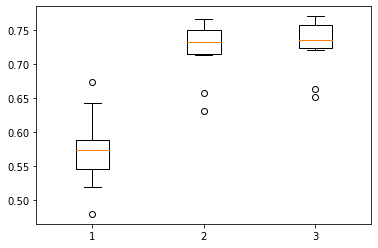

In [8]:
######
# your code here
######


*your answer here*

**Q1.2** Play around with $k$ in the $k$-fold cross-validation above.  Does the choice of the number of folds really matter?

In [ ]:
######
# your code here
######


In [ ]:
*your answer here*

**Q1.3** Build your own bootstrap cross-validation approach below (a skeleton is provided).  Do you see the same result comparing these 3 models?  What are the advantages to $k$-fold and random subsets/bootstrap cross-validation?

In [ ]:

nboots = 100
n_train = train.shape[0]
traincv_size = 0.8
n_traincv = int(traincv_size*n_train)
r2_cv_maineffects = []
r2_cv_interact = []
r2_cv_backwards = []


for boot in np.arange(nboots):
    traincv_indices = np.random.choice(n_train,n_traincv,replace=False)
    
    y_traincv, y_testcv = y_train[traincv_index], y_train[testcv_index]
        
    X_maineffects_traincv, X_maineffects_testcv = X_train.loc[traincv_index], X_train.loc[testcv_index]
    X_interact_traincv, X_interact_testcv = X_interact.loc[traincv_index], X_interact.loc[testcv_index]
    X_backwards_traincv, X_backwards_testcv = X_backwards.loc[traincv_index], X_backwards.loc[testcv_index]

    model1 = LinearRegression(fit_intercept=True).fit(X_maineffects_traincv, y_traincv)
    model2 = LinearRegression(fit_intercept=True).fit(X_interact_traincv, y_traincv)
    model3 = LinearRegression(fit_intercept=True).fit(X_backwards_traincv, y_traincv)

    r2_cv_maineffects.append(sk.metrics.r2_score(y_testcv, model1.predict(X_maineffects_testcv)))
    r2_cv_interact.append(sk.metrics.r2_score(y_testcv, model2.predict(X_interact_testcv)))
    r2_cv_backwards.append(sk.metrics.r2_score(y_testcv, model3.predict(X_backwards_testcv)))
 
    ######
    # your code here
    ######
    

In [22]:
nboots = 100
n_train = train.shape[0]
traincv_size = 0.8
n_traincv = int(traincv_size*n_train)
r2_cv_maineffects = []
r2_cv_interact = []
r2_cv_backwards = []
y_train = train['votergap']

traincv_indices = np.random.choice(n_train,n_traincv,replace=False)
print(y_train[1])
print(y_train[!1])

SyntaxError: invalid syntax (<ipython-input-22-62a6e6ae247d>, line 12)

*your answer here*

## Part 2: Data augmentation

In this section, we will create two different desgin matrices that will be used going forward for applying reularization to.  The first is a high-order (10) polynomial regression using `log-minority` only, and the second is a high-dimensional design matrix considering all factors.

In [ ]:
X_minority_poly = PolynomialFeatures(10, include_bias=False).fit_transform(train[['log_minority']])

regress_minority_poly = LinearRegression(fit_intercept=True).fit(X_minority_poly , train['votergap'])
print("Beta0 =", regress_minority_poly.intercept_ ,", Beta1 =", regress_minority_poly.coef_)



**Q2.1** Plot the predicted curves on top of the scatterplot of `votergap` vs. `log_minority` (the notebook from lecture 4 might be helpful for this).  What do you notice?



In [1]:
######
# your code here
######



*your answer here*

**Q2.2** Create a design matrix (call it `X_over`) with all the interactions and 4th-order polynomials based on the original list of 11 predictors: 

predictors = ['log_population','log_hispanic', 'log_minority', 'female', 
             'unemployed', 'income', 'nodegree', 'bachelor', 'inactivity', 'obesity', 'log_density']

How many predictors does this create?  Justify this number mathematically (it is not easy).

In [ ]:
######
# your code here: create X_over 
######



*your answer here*


**Q2.3** Fit the linear model using the over-parameterized design matrix above.  How does it perform on the test set?

In [ ]:
######
# your code here
######

*your answer here*

## Part 3: Regularization: Ridge and LASSO

In this part we will explore the effects of regularization on linear regression modeling.  First using the 20th order polynomial version of log_minority, then using the over-parameterized design matrix.


**Q3.1** Fit a Ridge model with $\alpha = 1$, $\alpha = 10$, and a LASSO model with $\alpha = 1$, and $\alpha = 10$ using the `X_minority_poly` design matrix.  Compare the estimated coefficients for all 5 models.

In [ ]:

# we give the first one to you
ridge_alpha1 = Ridge(alpha=1,fit_intercept=True).fit(X_minority_poly , train['votergap'])
print("Beta0 =", ridge_alpha1.intercept_ ,", Beta1 =", ridge_alpha1.coef_)


######
# your code here
######


*your answer here*



**Q3.2**  Plot the predictions (on top of the scatterplot) for all 5 models.  What do you notice?

In [ ]:
######
# your code here
######


*your answer here*



**Q3.3** For Ridge, *tune* the penalty terms using the test set.  Which value did you choose? How does this perform on the test set?

In [ ]:
######
# your code here
######

*your answer here*



## Part 4: Ridge and LASSO with CV

In this part we will use cross-validation to *tune* the penalization term ($\alpha$) in both ridge and LASSO regressions for the 

**Q4.1** Use [ridgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) and [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) to tune the models using 5-fold cross-validation for the 10$^{th}$ order polynomial of `log_minority`.  You may need to play around with the values of $\alpha$ you should consider. 

In [ ]:
######
# your code here
######

*your answer here*



**Q4.2** How do the best choices of $\alpha$ compare for Ridge and Lasso?  Why is this not surprising, mathematically?

*your answer here*



**Q4.3** Why is it important to not include the bias term when creating the design matrices?  Why is it important to normalize the predictors?  Were these precautions taken here?

*your answer here*



**Q4.4** Fit a well-tuned regularization model on the overly parameterized design matrix `X_over`.  How does this perform on the test set?

In [ ]:
######
# your code here
######

*your answer here*

